In [3]:
from ase.build import bulk
import lutorpy as lua
import numpy as np
import matplotlib.pyplot as plt

## use require("MODULE") to import lua modules
require("nn")
require("poten") # <-- This is the driver package, POTEN for INN model 
require("optim")

# poten package dataset definitions for Torch7/Lua
torch.setdefaulttensortype('torch.DoubleTensor')
lua.execute('''
    dataset={}
    function dataset:create()
        o={}
        setmetatable(o,self)
        self.__index=self
        return o
    end
    function dataset:size()
        return #self
    end
''')
lua_copy = lua.eval('''
    function(L)
        t = dataset:create()
        for item in python.iter(L) do
            table.insert(t, item)
        end
        return t
    end
    ''')
torch_sub = lua.eval('''
    function(A, B)
        return A - B
    end
    ''')

from pylab import *
from scipy.optimize import leastsq

def Murnaghan(parameters, vol):
    'From Phys. Rev. B 28, 5480 (1983)'
    E0, B0, BP, V0 = parameters

    E = E0 + B0 * vol / BP * (((V0 / vol)**BP) / (BP - 1) + 1) - V0 * B0 / (BP - 1.0)

    return E

def objective(pars, y, x):
    #we will minimize this function
    err =  y - Murnaghan(pars, x)
    return err

def bulk_modulus(vols, energies, cell_size):
    '''
    the parabola does not fit the data very well, but we can use it to get
    some analytical guesses for other parameters.
    
    V0 = minimum energy volume, or where dE/dV=0
    E = aV^2 + bV + c
    dE/dV = 2aV + b = 0
    V0 = -b/2a
    
    E0 is the minimum energy, which is:
    E0 = aV0^2 + bV0 + c
    
    B is equal to V0*d^2E/dV^2, which is just 2a*V0
    and from experience we know Bprime_0 is usually a small number like 4
    '''
    a, b, c = polyfit(vols, energies, 2)
    v0 = -b / (2 * a)
    e0 = a * v0 ** 2 + b * v0 + c
    b0 = 2 * a * v0
    bP = 4
    x0 = [ e0, b0, bP, v0] #initial guess of parameters
    plsq = leastsq(objective, x0, args=(energies, vols))
    BmodGPa = plsq[0][1] * 160.2176487
    print 'Bulk Modulus in GPa: {0}'.format(BmodGPa)
    alen = (plsq[0][3]/np.prod(cell_size)) ** (1 / 3.0)
    print 'Equlibrium lattice constant: {0}'.format(alen)
    
    plt.plot(vols,energies, 'ro')
    x = np.linspace(min(vols), max(vols), 50)
    y = Murnaghan(plsq[0], x)
    plt.plot(x, y, 'k-')
    plt.xlabel('Volume (A^3)')
    plt.ylabel('Energy (eV)')
    plt.show()

def prediction(mlp, atomlist, atomdata, symdata, sympack, pcadata, forces=False):
    # Setup poten with symmetry func. data
    INNpoten = poten.Energy(symdata)
    # Setup input structure (Atoms) data
    INNpoten._setStructure(atomdata)
    INNinputList = INNpoten._neighborUpdate()
    INNinput = INNpoten._update()
    #INNinput = INNpoten._inputUpdate()
    pred = 0.0
    shift = 0
    numTypes = int(sympack[1])
    natoms = int(atomlist[0])
    numsym = int(sympack[4])
    avgenergy = pcadata[0]
    stdenergy = pcadata[1]
    AVGtensor = pcadata[2]
    STDtensor = pcadata[3]
    PCAtensor = pcadata[4]
    INNderivs=np.zeros((natoms,numsym))
    gOutTensor=torch.Tensor(1)._fill(1.0)
    for t in range(numTypes):
        typatoms = int(atomlist[t+1])
        if typatoms>0:
            TYPtensor = INNinput._sub(shift+1,shift+typatoms)
            for j in range(typatoms):
                TYPtensor[j] = torch_sub(TYPtensor[j], AVGtensor[t])
            TYPinput = torch.mm(TYPtensor, PCAtensor[t])
            for j in range(typatoms):
                TYPtensor[j]._cmul(TYPinput[j], STDtensor[t])
            drvnn = mlp.modules[0].modules[t]
            for j in range(typatoms):
                total = drvnn._updateOutput(TYPtensor[j])
                pred  = pred + total[0]
                if forces:
                    dOutdIn = drvnn._updateGradInput(TYPtensor[j], gOutTensor)
                    ddOutdIn = torch.cmul(dOutdIn, STDtensor[t])
                    dOutdIn._mv(PCAtensor[t], ddOutdIn)
                    INNderivs[shift+j] = dOutdIn.asNumpyArray()
            shift = shift + typatoms
    if forces:
        forces = INNpoten._updateForces(torch.fromNumpyArray(INNderivs))
        return pred, forces.asNumpyArray()
    else:
        return pred

def atoms2table(aseatoms, typelist):
    symbols = aseatoms.get_chemical_symbols()
    numTypes = len(typelist)
    numParts = int(len(aseatoms.positions))
    partList=np.zeros(numParts)
    partSpecies=np.zeros(numParts)
    atomPositions=np.asarray(aseatoms.positions)
    unitvecs=np.asarray(aseatoms.cell)
    atomlist=np.zeros(numTypes+1)
    atomlist[0]=int(numParts)
    
    for ie, element in enumerate(symbols):
        if element in typeslist:
            partSpecies[ie] = typeslist.index(element)+1
            atomlist[typeslist.index(element)+1] += 1
        partList[ie]=ie+1
        
    atomdata = lua_copy([
        numParts,
        torch.fromNumpyArray(unitvecs),
        torch.fromNumpyArray(partList),
        torch.fromNumpyArray(partSpecies),
        torch.fromNumpyArray(atomPositions)
    ])
    return atomlist, atomdata

def read_sym_pca_data(symfilename):
    fd = open(symfilename, "r")
    cutoff  = float(fd.readline())
    num_typ = int(fd.readline())
    num_rad = int(fd.readline())
    rad_eta = np.zeros(num_rad)
    for j in range(num_rad):
        rad_eta[j] = float(fd.readline()) 
    num_ang = int(fd.readline())
    ang_eta = np.zeros(num_ang)
    lambd = np.zeros(num_ang)
    zeta = np.zeros(num_ang)
    for j in range(num_ang):
        ang_eta[j] = float(fd.readline())
    for j in range(num_ang):
        lambd[j] = float(fd.readline())
    for j in range(num_ang):
        zeta[j] = float(fd.readline())
    averageatoms = int(fd.readline())
    avgenergy = float(fd.readline())
    comb = np.math.factorial(num_typ) / (2 *  np.math.factorial(num_typ-2) )
    num_sym = num_typ*num_rad + (num_typ + comb)*num_ang
    avgsym = np.zeros((num_typ, num_sym))
    for t in range(num_typ):
        for j in range(num_sym):
            avgsym[t][j] = float(fd.readline())
    stdenergy = float(fd.readline())
    stdsym = np.zeros((num_typ, num_sym))
    for t in range(num_typ):
        for j in range(num_sym):
            stdsym[t][j] = 1.0 / float(fd.readline())
    pca = np.zeros((num_typ, num_sym, num_sym))
    for t in range(num_typ):
        for i in range(num_sym):
            line=fd.readline().split()
            for j in range(num_sym):
                pca[t][j][i] = float(line[j])
    pypack = [
        cutoff,
        num_typ,
        num_rad,
        num_ang,
        num_sym
    ]
    thedata = lua_copy([
        cutoff,
        num_typ,
        num_rad,
        num_ang,
        torch.fromNumpyArray(rad_eta),
        torch.fromNumpyArray(ang_eta),
        torch.fromNumpyArray(lambd),
        torch.fromNumpyArray(zeta)
    ])
    pcadata = lua_copy([
        avgenergy,
        stdenergy,
        torch.fromNumpyArray(avgsym),
        torch.fromNumpyArray(stdsym),
        torch.fromNumpyArray(pca)
    ])
    fd.close()
    print('Symmetry function parameters read from file ' + str(symfilename))
    print('Cutoff is ' + str(cutoff))
    print('Number of types : ' + str(num_typ))
    print('Radial Sym. Funcs : ' + str(num_rad))
    print('Angular Sym. Funcs : ' + str(num_ang))
    return pypack, thedata, pcadata

typeslist = ['Si', 'Li'] # Order of elements as seen in NN. Ex. Si=1, Li=2.
innsymfilename='SYMparams.txt' # This is the file that stores the parameters. 
innfilename='INNparams.txt' # This is the file that stores the NN Architecture in Torch7 format. 
innsympack, innsymdata, innpcadata = read_sym_pca_data(innsymfilename)
inn_mlp=torch.load(innfilename, 'ascii')
print("INN Architecture:")
print(inn_mlp)

Symmetry function parameters read from file SYMparams.txt
Cutoff is 6.0
Number of types : 2
Radial Sym. Funcs : 8
Angular Sym. Funcs : 22
INN Architecture:
nn.Sequential {
  [input -> (1) -> (2) -> (3) -> output]
  (1): nn.ParallelTable {
    input
      |`-> (1): nn.Sequential {
      |      [input -> (1) -> (2) -> output]
      |      (1): nn.Sequential {
      |        [input -> (1) -> (2) -> (3) -> (4) -> (5) -> output]
      |        (1): nn.Linear(82 -> 32)
      |        (2): nn.Tanh
      |        (3): nn.Linear(32 -> 32)
      |        (4): nn.Tanh
      |        (5): nn.Linear(32 -> 1)
      |      }
      |      (2): nn.Sum
      |    }
       `-> (2): nn.Sequential {
             [input -> (1) -> (2) -> output]
             (1): nn.Sequential {
               [input -> (1) -> (2) -> (3) -> (4) -> (5) -> output]
               (1): nn.Linear(82 -> 16)
               (2): nn.Tanh
               (3): nn.Linear(16 -> 16)
               (4): nn.Tanh
               (5): nn.Linear

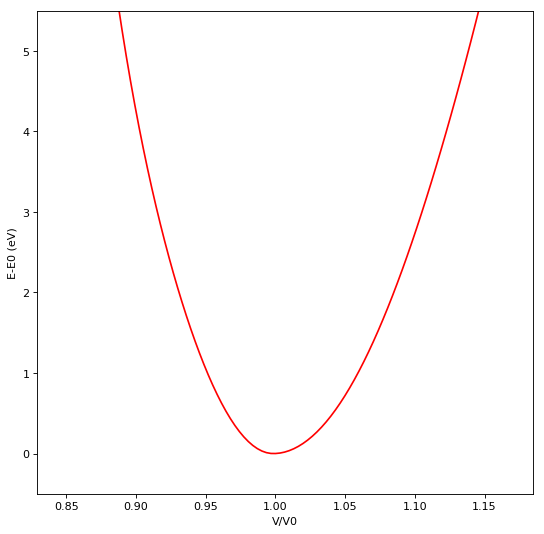

In [4]:
# Si Diamond Lattice Constant Test
steps=100
a_0 = 5.51
cell_size = (2, 2, 2)
inn_pred_list = []
inn_lata_list = []
for x in range(steps):
    da = 0.6/steps
    lata = a_0 - 0.30 + da * x
    si = bulk('Si', a=lata, cubic=True) * cell_size
    atomlist, atomtable = atoms2table(si, typeslist)
    innenergy = prediction(inn_mlp, atomlist, atomtable, innsymdata, innsympack, innpcadata)
    inn_lata_list.append(lata*lata*lata*np.prod(cell_size))
    inn_pred_list.append(innenergy)
    #print('lat_a:',lata, 'INN Energy:',innenergy)

vols=np.asarray(inn_lata_list)
inn_energies=np.asarray(inn_pred_list)
fig = plt.figure(figsize=(8, 8), dpi= 80,)
plt.plot(vols/(a_0*a_0*a_0*np.prod(cell_size)), (inn_energies-np.min(inn_energies)), 'r-')
plt.xlabel('V/V0')
plt.ylabel('E-E0 (eV)')
axes = plt.gca()
axes.set_ylim([-0.5,5.5])
plt.show()

Bulk Modulus in GPa: 82.1785332649
Equlibrium lattice constant: 5.5110235268


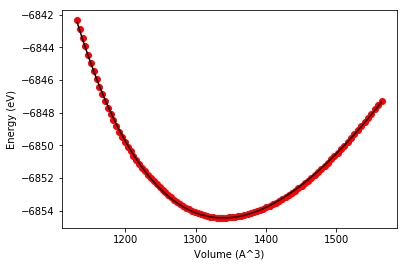

In [5]:
# Si Diamond Bulk Modulus Test
bulk_modulus(vols, inn_energies, cell_size)